In [3]:
import os
import pandas as pd

# ✅ Update this path to match your folder
IMAGE_FOLDER = r"C:\Users\mcsmu\Desktop\Autonomous A LAB\Dataset\teamD_dataset\Processed Dataset"
LABELS_FILE = r"C:\Users\mcsmu\Desktop\Autonomous A LAB\Dataset\teamD_dataset\labels.csv"

# Load the labels
labels_df = pd.read_csv(LABELS_FILE)
labels_df.head()


,00815481.png,0
0,00815521.png,1
1,00815561.png,0
2,00815602.png,0
3,00815643.png,0
4,00815684.png,0


In [4]:
import cv2
import numpy as np

def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Resize for consistency
    img = cv2.resize(img, (160, 120))

    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define green-cyan mask
    lower = np.array([40, 100, 150])
    upper = np.array([95, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)

    # Focus on bottom half (where the line is expected)
    roi = mask[mask.shape[0]//2:, :]

    # Get X positions of green pixels
    coords = np.column_stack(np.where(roi > 0))

    if coords.shape[0] == 0:
        return [0]  # No green line found

    mean_x = np.mean(coords[:, 1])  # column index is x
    return [mean_x / roi.shape[1]]  # Normalize (0 to 1)


In [6]:
print(labels_df.columns)


Index(['00815481.png', '0'], dtype='object')


In [7]:
labels_df = pd.read_csv(LABELS_FILE, header=None)
labels_df.columns = ['filename', 'label']


In [8]:
X = []
y = []

for _, row in labels_df.iterrows():
    image_path = os.path.join(IMAGE_FOLDER, row['filename'])
    features = extract_features(image_path)
    
    if features is not None:
        X.append(features)
        y.append(row['label'])


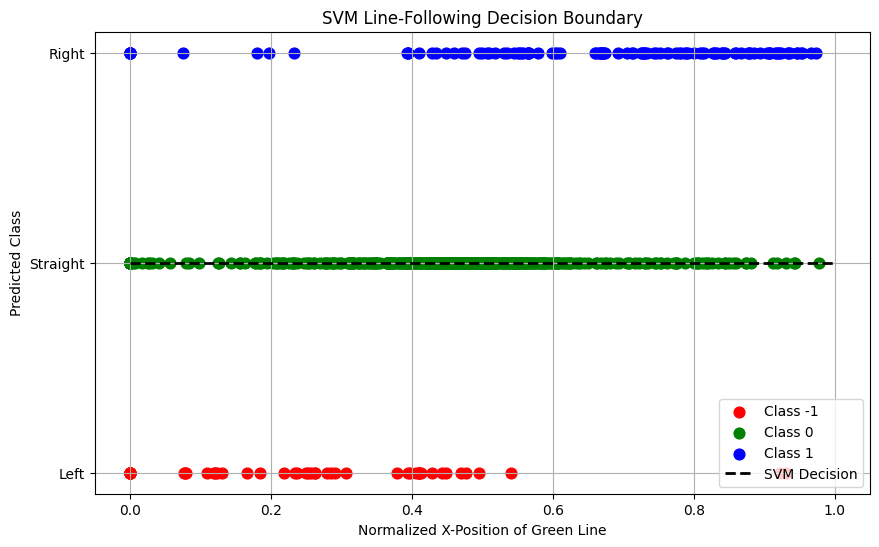

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Convert lists to arrays if needed
X = np.array(X)
y = np.array(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM model
model = SVC(kernel='linear')
model.fit(X_train, y_train)

# Generate values across feature range (0 to 1)
x_range = np.linspace(0, 1, 300).reshape(-1, 1)
y_range_pred = model.predict(x_range)

# Plot training points
plt.figure(figsize=(10, 6))
colors = {-1: "red", 0: "green", 1: "blue"}

for label in np.unique(y_train):
    plt.scatter(
        X_train[y_train == label], 
        [label] * len(X_train[y_train == label]),
        c=colors[label], label=f"Class {label}", s=60
    )

# Plot SVM prediction line
plt.plot(x_range, y_range_pred, 'k--', label="SVM Decision", linewidth=2)

# Labels
plt.title("SVM Line-Following Decision Boundary")
plt.xlabel("Normalized X-Position of Green Line")
plt.ylabel("Predicted Class")
plt.yticks([-1, 0, 1], ["Left", "Straight", "Right"])
plt.grid(True)
plt.legend()
plt.show()


✅ Test Accuracy: 74.42%

📋 Classification Report:
              precision    recall  f1-score   support

   Left (-1)       0.00      0.00      0.00        16
Straight (0)       0.74      1.00      0.85       128
   Right (1)       0.00      0.00      0.00        28

    accuracy                           0.74       172
   macro avg       0.25      0.33      0.28       172
weighted avg       0.55      0.74      0.64       172



C:\Users\mcsmu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mcsmu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mcsmu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

<Figure size 600x500 with 0 Axes>

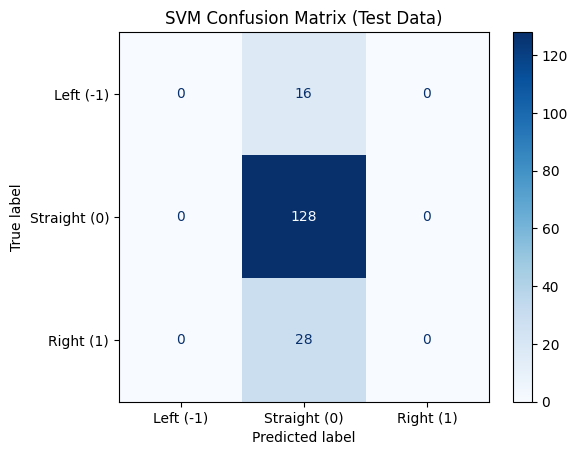

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the 20% test set
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Left (-1)", "Straight (0)", "Right (1)"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Left (-1)", "Straight (0)", "Right (1)"])

# Show Confusion Matrix
plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("SVM Confusion Matrix (Test Data)")
plt.show()
